In [ ]:
!pip install calplot

In [ ]:
#connect with drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/Bo_RA/

In [3]:
import pandas as pd
import warnings
import calplot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
#read the type 1 app datasets
t1_unit = pd.read_stata('top_units_US_unified_2020_10k.dta')[['app_id', 'platform', 'app_id_unified']]
t1_revenue = pd.read_stata('top_revenue_US_unified_2020_10k.dta')[['app_id', 'platform', 'app_id_unified']]
#read the type 2 app datasets and merge
#took 20s
t2_unit = pd.read_stata('top_units_US_panel_2018-2021_tsfilled.dta')[['app_id_unified', 'rank']].drop_duplicates() #6518
df_unit = pd.merge(t1_unit, t2_unit, on = 'app_id_unified', how = 'outer')
t2_revenue = pd.read_stata('top_revenue_US_panel_2018-2021_tsfilled.dta')[['app_id_unified', 'rank']].drop_duplicates()#6032
df_revenue = pd.merge(t1_revenue, t2_revenue, on = 'app_id_unified', how = 'outer')

In [5]:
#read the version update datasets and form app lists
#took ~2min
ios_df = pd.read_pickle('ios_app.pickle')[['app_id', 'version', 'date',
                 'len_word', 'len_char', 'update_by_num', 'len_char_ttl',
                 'para', 'update_by_direct_mention', 
                 'privacy_mention', 'update_by_feature_bug',
                 'update_by_num_modified', 'update_by_para', 'system_mention',
                 'feature_score', 'bug_score', 'update_num_dist', 'min_max_diff']]
ios_update = set(ios_df['app_id'])
and_df = pd.read_pickle('android_app.pickle')[['app_id', 'version', 'date',
                 'len_word', 'len_char', 'update_by_num', 'len_char_ttl',
                 'para', 'update_by_direct_mention', 
                 'privacy_mention', 'update_by_feature_bug',
                 'update_by_num_modified', 'update_by_para', 'system_mention',
                 'feature_score', 'bug_score', 'update_num_dist', 'min_max_diff']]
and_update = set(and_df['app_id'])

1. At the unified app_id level, flag apps you only find version updates in one store but not the other (e.g., version updates in ios but no version updates in Android). This is to confirm the heatmap pattern is not driven by missing data or sample selection/truncation. For the new heatmaps, only include apps that both ios and Android have version updates.

In [6]:
#add a flag for type 2 apps
df_unit['is_t2'] = df_unit['rank'].apply(lambda x: 0 if pd.isna(x) else 1)
df_revenue['is_t2'] = df_revenue['rank'].apply(lambda x: 0 if pd.isna(x) else 1)
#check if the apps are in the version update dataset
df_unit['in_ios_update'] = df_unit['app_id'].apply(lambda x: 1 if x in ios_update else 0)
df_revenue['in_ios_update'] = df_revenue['app_id'].apply(lambda x: 1 if x in ios_update else 0)
df_unit['in_and_update'] = df_unit['app_id'].apply(lambda x: 1 if x in and_update else 0)
df_revenue['in_and_update'] = df_revenue['app_id'].apply(lambda x: 1 if x in and_update else 0)

In [14]:
#identify apps that are in both the ios and android version update datsets
#complete_update = 1 if all apps sharing the same unified id can be found in the version update dataset
df_temp = \
pd.merge(df_unit.groupby('app_id_unified').sum().reset_index()[['app_id_unified', 'in_ios_update', 'in_and_update']],
         df_unit.groupby('app_id_unified').count().reset_index()[['app_id_unified', 'app_id']],
         on = 'app_id_unified')
df_temp['complete_update'] = df_temp.apply(lambda x: 1 if x['in_ios_update'] + x['in_and_update'] == x['app_id'] else 0, axis = 1)
df_unit = pd.merge(df_unit,#[['app_id', 'platform', 'app_id_unified', 'rank', 'is_t2']], 
                   df_temp[['app_id_unified', 'complete_update']], on = 'app_id_unified')

In [16]:
df_temp = None
df_temp = \
pd.merge(df_revenue.groupby('app_id_unified').sum().reset_index()[['app_id_unified', 'in_ios_update', 'in_and_update']],
         df_revenue.groupby('app_id_unified').count().reset_index()[['app_id_unified', 'app_id']],
         on = 'app_id_unified')
df_temp['complete_update'] = df_temp.apply(lambda x: 1 if x['in_ios_update'] + x['in_and_update'] == x['app_id'] else 0, axis = 1)
df_revenue = pd.merge(df_revenue,
                      df_temp[['app_id_unified', 'complete_update']], on = 'app_id_unified')

In [58]:
#take a look
df_unit.head(10)

,app_id,platform,app_id_unified,rank,is_t2,in_ios_update,in_and_update,complete_update
0,us.zoom.videomeetings,android,5379e662830f782dbe0067fc,1.0,1,0,1,1
1,546505307,ios,5379e662830f782dbe0067fc,1.0,1,1,0,1
2,com.zhiliaoapp.musically,android,56cbbce9d48401b048003405,2.0,1,0,1,1
3,835599320,ios,56cbbce9d48401b048003405,2.0,1,1,0,1
4,com.facebook.mlite,android,55c501db02ac64f9c0001f52,3.0,1,0,1,1
5,com.facebook.orca,android,55c501db02ac64f9c0001f52,3.0,1,0,1,1
6,454638411,ios,55c501db02ac64f9c0001f52,3.0,1,1,0,1
7,com.innersloth.spacemafia,android,5b2483b6c66f8810923556fc,4.0,1,0,1,1
8,1351168404,ios,5b2483b6c66f8810923556fc,4.0,1,1,0,1
9,com.facebook.lite,android,55c530a702ac64f9c0002dff,5.0,1,0,1,1


In [38]:
ios_t2_unit = set(df_unit[(df_unit['is_t2'] == 1) & (df_unit['complete_update'] == 1) & (df_unit['platform'] == 'ios')]['app_id']) #5474
and_t2_unit = set(df_unit[(df_unit['is_t2'] == 1) & (df_unit['complete_update'] == 1) & (df_unit['platform'] == 'android')]['app_id']) #5468
ios_t2_revenue = set(df_revenue[(df_revenue['is_t2'] == 1) & (df_revenue['complete_update'] == 1) & (df_revenue['platform'] == 'ios')]['app_id']) #3475
and_t2_revenue = set(df_revenue[(df_revenue['is_t2'] == 1) & (df_revenue['complete_update'] == 1) & (df_revenue['platform'] == 'android')]['app_id']) #3470

2. Follow-up work on heatmaps for the top 10k apps (total, major, minor) from 2019 to 2022 (inclusive). This time, please add the month frame in the heatmap. Besides ios and Android, please also plot an additional heat map for "ios - android" or "android - ios" (either is fine). This removes the influence of weekends/holidays and makes slight differences more noticeable. Also, please put unit and revenue figures in separate folders for ease of reference. 
Currently I am a bit worried that Android has a higher update frequency relative to ios right before the label policy (see the intensity of the blue colour below). Major and minor updates also show this pattern to some extent (see the intensive blue in Android at the end of 2020). One potential reason for could be due to the weird pattern we see in the top 50 firms (see the unusually light colour from April 2018 to October 2020 for Android). I trust your good work but we need to confirm this pattern by checking a few examples. Can you pick several apps from the top 50 and see if there are indeed large discrepancy between ios and android updates frequency? If so, find the apps that contribute the most to the discrepancy.


In [39]:
#identify type 2 apps in the version update dataset
ios_df['is_t2_unit'] = ios_df['app_id'].apply(lambda x: 1 if x in ios_t2_unit else 0)
ios_df['is_t2_revenue'] = ios_df['app_id'].apply(lambda x: 1 if x in ios_t2_revenue else 0)
and_df['is_t2_unit'] = and_df['app_id'].apply(lambda x: 1 if x in and_t2_unit else 0)
and_df['is_t2_revenue'] = and_df['app_id'].apply(lambda x: 1 if x in and_t2_revenue else 0)

In [42]:
#generate a dataframe of complete dates
full_date_df = pd.DataFrame()
start_date = '2019-01-01'
end_date = '2022-12-31'
full_date_df['date'] = pd.date_range(start_date, end_date, freq='D').strftime("%Y-%m-%d").tolist()

In [ ]:
#plot heatmaps with all combinations of measures and parameters

##############
#Run the functions at the end of this notebook before this line
##############

#all update
plot_all_update(ios_df, platform = 'ios', sort = 'unit')
plot_all_update(ios_df, platform = 'ios', sort = 'revenue')
plot_all_update(and_df, platform = 'Android', sort = 'unit')
plot_all_update(and_df, platform = 'Android', sort = 'revenue')

#major update
for m in ['direct mention', 'para', 'num modified', 'feature bug']:
    for s in ['unit', 'revenue']:
        for i in [0, 1]:
            plot_major_update([ios_df, and_df][i], platform = ['ios', 'Android'][i], sort = s, how = m)

#minor update
for m in ['direct mention', 'para', 'num modified', 'feature bug']:
    for s in ['unit', 'revenue']:
        for i in [0, 1]:
            plot_minor_update([ios_df, and_df][i], platform = ['ios', 'Android'][i], sort = s, how = m)

In [44]:
#display pic from file
def show_img(path):
    image = Image.open(path)
    fig = plt.figure(figsize=(6, 5), dpi=200)
    plt.imshow(image)
    plt.axis('off')
    plt.show();

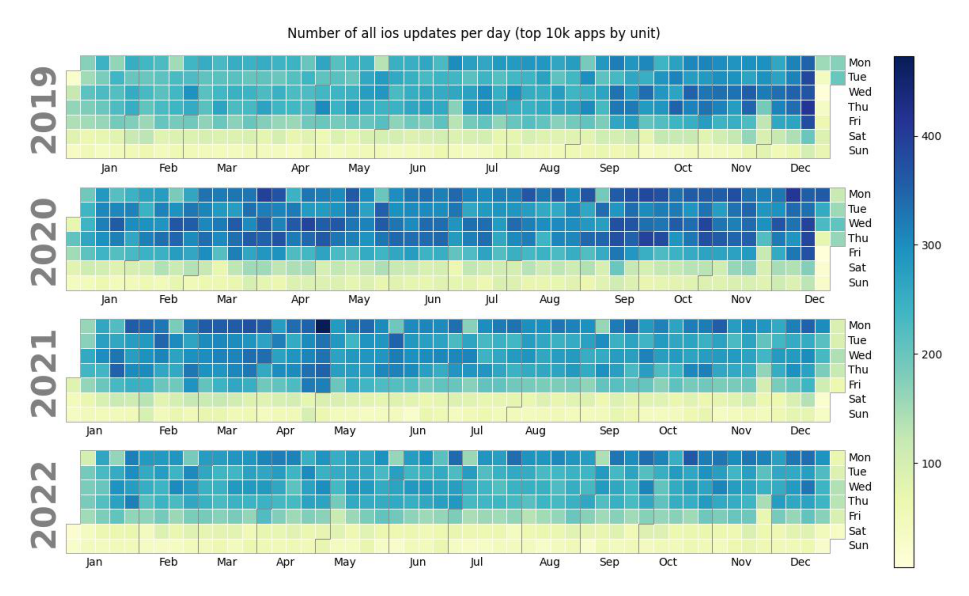

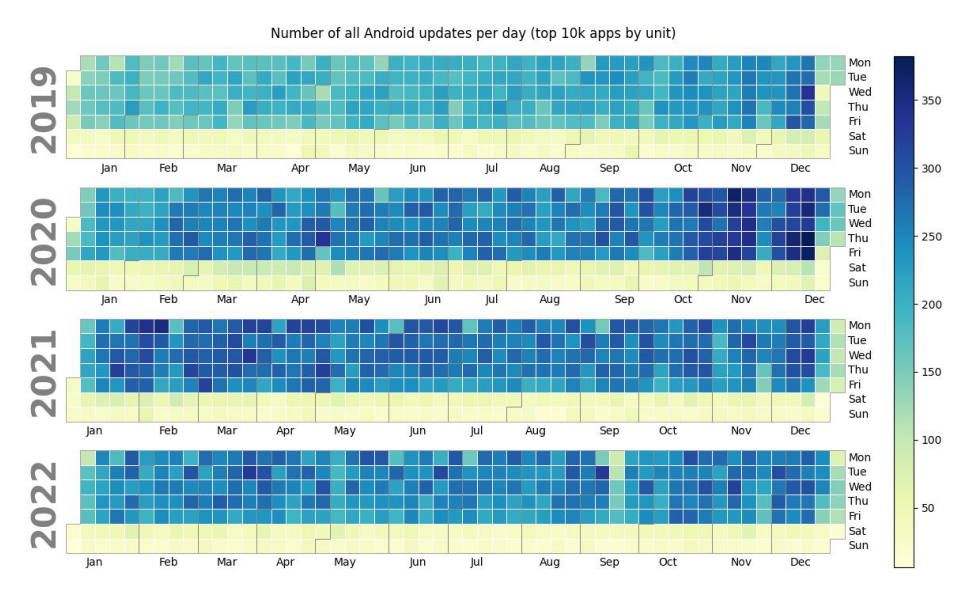

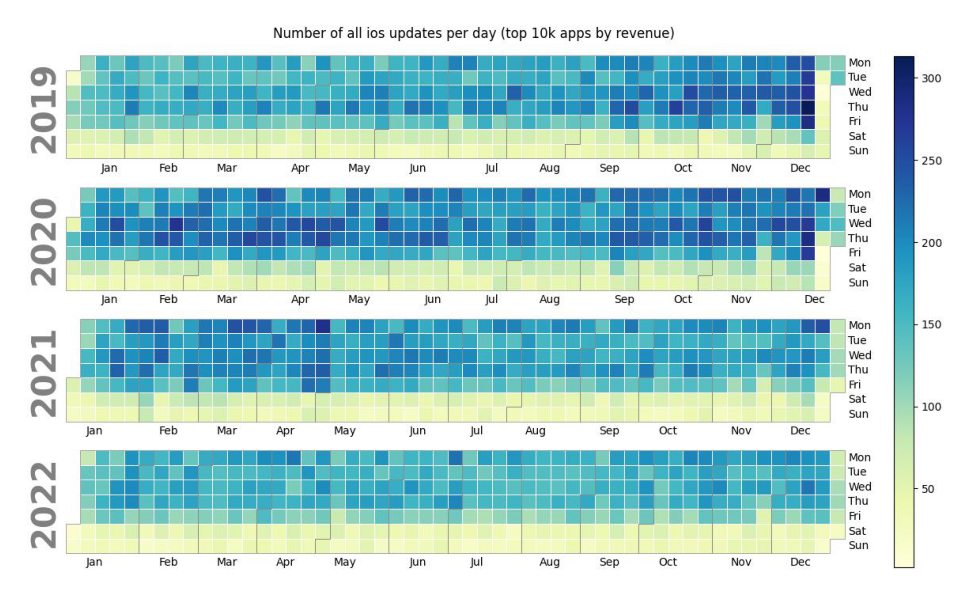

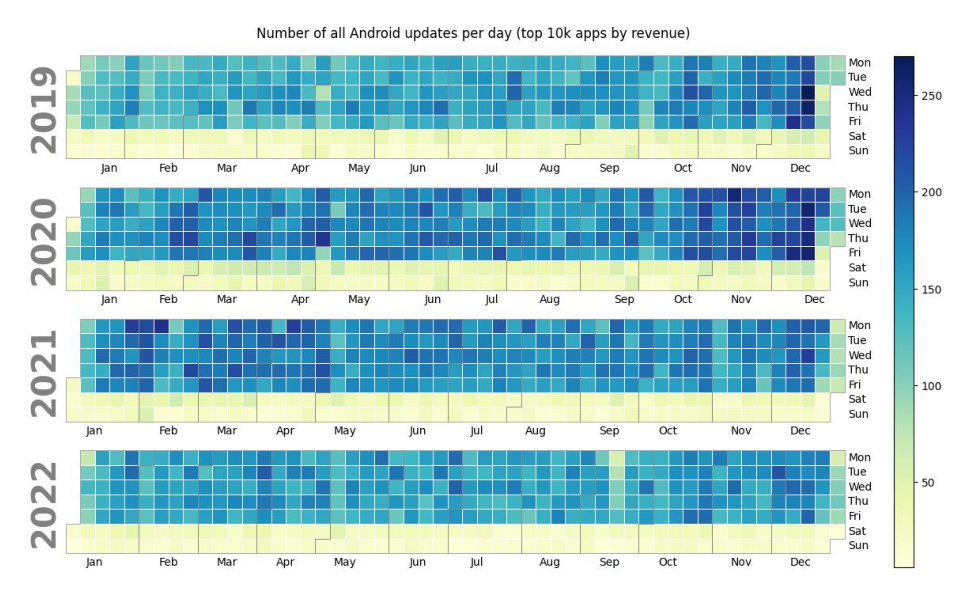

In [54]:
#show plots
#all updates
#2x2 = 4 graphs
for s in ['unit', 'revenue']:
    for p in ['ios', 'Android']:
        show_img('heatmaps/all_update_{}_{}_10k.jpg'.format(p, s))

In [ ]:
#TBD

#"ios - android" 

In [52]:
def plot_all_update(update_df, platform = 'ios', sort = 'unit', top = False):
    #first create a df of date level total number of update
    update_ttl = update_df[update_df['is_t2_{}'.format(sort)] == 1].groupby('date').count().reset_index()[['date', 'version']]
    if top:
        update_ttl = update_df[update_df['is_t2_{}_top'.format(sort)] == 1].groupby('date').count().reset_index()[['date', 'version']]
    #slice by start and end dates
    update_ttl = update_ttl.loc[(update_ttl['date'] >= start_date) & (update_ttl['date'] <= end_date)]
    #merge with the full date df
    update_ttl = pd.merge(full_date_df, update_ttl, how = 'left')
    update_ttl = update_ttl.fillna(0)#fill na with 0
    #create a pd series for calplot
    events = pd.Series(np.array(update_ttl['version']), index=pd.date_range(start_date, end_date, freq='D'))
    plt.figure(figsize=(10, 4))
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.2, bottom=0.1, top=0.9)

    #plot and save as jpg
    if not top:
        calplot.calplot(events, suptitle='Number of all {} updates per day (top 10k apps by {})'.format(platform, sort), 
                        cmap='YlGnBu', edgecolor='grey', linewidth=0.5)
        plt.savefig('heatmaps/all_update_{}_{}_10k.jpg'.format(platform, sort), format='jpg', bbox_inches='tight');
    else:
        calplot.calplot(events, suptitle='Number of all {} updates per day (top 50 apps by {})'.format(platform, sort), 
                        cmap='YlGnBu', edgecolor='grey', linewidth=0.5)
        plt.savefig('heatmaps/all_update_{}_{}_50.jpg'.format(platform, sort), format='jpg', bbox_inches='tight');


def plot_major_update(update_df, platform='ios', sort='unit', how='direct mention', top=False):
    # first create a df of date level number of major update
    update_major = update_df[update_df['is_t2_{}'.format(sort)] == 1].groupby('date').sum().reset_index()[
        ['date', 'update_by_{}'.format(how.replace(' ', '_'))]]
    if top:
        update_major = update_df[update_df['is_t2_{}_top'.format(sort)] == 1].groupby('date').sum().reset_index()[
            ['date', 'update_by_{}'.format(how.replace(' ', '_'))]]
    # slice by start and end dates
    update_major = update_major.loc[(update_major['date'] >= start_date) & (update_major['date'] <= end_date)]
    # merge with the full date df
    update_major = pd.merge(full_date_df, update_major, how='left')
    update_major = update_major.fillna(0)  # fill na with 0

    # create a pd series for calplot
    events = pd.Series(np.array(update_major['update_by_{}'.format(how.replace(' ', '_'))]),
                       index=pd.date_range(start_date, end_date, freq='D'))

    # plot and save as jpg
    if not top:
        calplot.calplot(events,
                        suptitle='Number of major {} updates per day (measured by {}, for top 10k apps sorted by {})'.format(
                            platform, how, sort), 
                        cmap='YlGnBu', edgecolor='grey', linewidth=0.5)
        plt.savefig('heatmaps/major_update_{}_{}_{}_10k.jpg'.format(platform, sort, how), format='jpg',
                    bbox_inches='tight');
    else:
        calplot.calplot(events,
                        suptitle='Number of major {} updates per day (measured by {}, for top 50 apps sorted by {})'.format(
                            platform, how, sort), 
                        cmap='YlGnBu', edgecolor='grey', linewidth=0.5)
        plt.savefig('heatmaps/major_update_{}_{}_{}_50.jpg'.format(platform, sort, how), format='jpg',
                    bbox_inches='tight');


def plot_minor_update(update_df, platform='ios', sort='unit', how='direct mention', top=False):
    # repeat the steps
    update_ttl = update_df[update_df['is_t2_{}'.format(sort)] == 1].groupby('date').count().reset_index()[
        ['date', 'version']]
    update_major = update_df[update_df['is_t2_{}'.format(sort)] == 1].groupby('date').sum().reset_index()[
        ['date', 'update_by_{}'.format(how.replace(' ', '_'))]]
    if top:
        update_major = update_df[update_df['is_t2_{}_top'.format(sort)] == 1].groupby('date').sum().reset_index()[
            ['date', 'update_by_{}'.format(how.replace(' ', '_'))]]
        update_ttl = update_df[update_df['is_t2_{}_top'.format(sort)] == 1].groupby('date').count().reset_index()[
            ['date', 'version']]
    update_major = update_major.loc[(update_major['date'] >= start_date) & (update_major['date'] <= end_date)]
    update_major = pd.merge(full_date_df, update_major, how='left')
    update_major = update_major.fillna(0)
    update_ttl = update_ttl.loc[(update_ttl['date'] >= start_date) & (update_ttl['date'] <= end_date)]
    update_ttl = pd.merge(full_date_df, update_ttl, how='left')
    update_ttl = update_ttl.fillna(0)

    # merge the ttl and major dfs and calculate minor update (ttl-major)
    update_minor = pd.merge(update_major, update_ttl)
    update_minor['minor'] = update_minor['version'] - update_minor['update_by_{}'.format(how.replace(' ', '_'))]

    # create a pd series for calplot
    events = pd.Series(np.array(update_minor['minor']), index=pd.date_range(start_date, end_date, freq='D'))

    # plot and save as jpg
    if not top:
        calplot.calplot(events,
                        suptitle='Number of minor {} updates per day (measured by {}, for top 10k apps sorted by {})'.format(
                            platform, how, sort), 
                        cmap='YlGnBu', edgecolor='grey', linewidth=0.5)
        plt.savefig('heatmaps/minor_update_{}_{}_{}_10k.jpg'.format(platform, sort, how), format='jpg',
                    bbox_inches='tight');
    else:
        calplot.calplot(events,
                        suptitle='Number of minor {} updates per day (measured by {}, for top 50 apps sorted by {})'.format(
                            platform, how, sort), 
                        cmap='YlGnBu', edgecolor='grey', linewidth=0.5)
        plt.savefig('heatmaps/minor_update_{}_{}_{}_50.jpg'.format(platform, sort, how), format='jpg',
                    bbox_inches='tight');